In [456]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import zscore
from scipy.spatial.distance import cdist


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

from pylab import *

import string

# PART A

## Common Functions

In [457]:

#read the file
def read_file(fileType, fileName):
    df = pd.DataFrame({'A' : []})
    if fileType == 'csv' :
        df= pd.read_csv(fileName)
    elif fileType == 'json' :
        df= pd.read_json(fileName)
    return df

#Merge both the DataFrames on join key
def merge(df1, df2, joinKey):
    return pd.merge(df1,df2, on=joinKey)

#Draw box plot
def box_plot(df):
    print('\n Box Plot - 5 Number summary for Numeric features \n')
    numeric_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'float64' or df[x].dtype == 'int')]  # Non object columns

    plt.figure(figsize = (20,3))
    plt.subplots_adjust(hspace=0.9)
    plt.subplots_adjust(wspace=0.2)
    cols=3
    rows = len(numeric_col) // cols + (len(numeric_col) % cols > 0)
    for n, i in enumerate(numeric_col):
        ax = plt.subplot(rows, cols, n + 1)
        sns.boxplot(x=df[i], ax=ax)
        ax.set_title(i.upper())
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.show()

#transform string/object to float data type
def string_to_float(df, include):
    for feature in df.columns: # Loop through all columns in the dataframe
        if (feature in include and df[feature].dtype == 'object' ): # Only apply for columns with categorical strings
            df[feature] = pd.to_numeric(df[feature], errors='coerce') # Replace strings with a Float
    return df

# converts to Category type.
def to_category(df, include):
    for feature in df.columns: # Loop through all columns in the dataframe
        if ( feature in include  ): # Only apply for columns with categorical strings
            df[feature] = pd.Categorical(df[feature])# Replace strings with an integer
    return df

#return null values percentage
def null_percentage(df):
    return  100 * (df.isnull().sum()/len(df))

#Draw Pair Plot
def pair_plot(df):
    plt.figure(figsize = (20,3))
    sns.pairplot(df);
    plt.show()

# draw scatter plot
def scatter_plot(x_feature, y_feature, df, hue_feature):
    sns.scatterplot(x=x_feature, y =y_feature , data=df, hue=hue_feature)

#get value counts
def value_counts(df):
    for feature in df.columns: # Loop through all columns in the dataframe
        print(df[feature].value_counts())
        
#has special characters
def has_special_char(df, col):
    unwanted = string.ascii_letters + string.punctuation + string.whitespace
    print(df[df[col].str.strip(unwanted).astype(bool)==False])

# duplicate values
def duplicate_values(df):
    return df[df.duplicated()]

# impute missing values by median
def impute_missing_by_median(df, include):
    for feature in df.columns: # Loop through all columns in the dataframe
        if (feature in include ): # Only apply for columns with categorical strings
            df[feature]=df[feature].fillna(df[feature].median()) # Impute missing By Median
    return df

# normalizing data
def normalize_data(df, cols):
    new_cols = [f"{c}_zscore" for c in cols]
    dfz = df.copy()
    dfz[new_cols]=  df[cols].apply(zscore)  
    dfz.drop(cols, axis = 1 , inplace=True)
    return dfz


#kmeans clustering
def kmeans(fuel_dfz, n_clusters,  rs=1):
    df=pd.DataFrame()
    df=fuel_dfz.copy()
    km = KMeans(n_clusters = n_clusters,  random_state=rs)
    km.fit(df)
    centroids = pd.DataFrame(km.cluster_centers_, columns = list(df))
    prediction = km.predict(df)
    k=n_clusters
    col = 'k_'+str(k)
    df[col] = prediction
    df[col] = df[col].astype('category')
    print("\n\n K-Means clustering with ",k,"Clusters")
    print("-----------------------------------")
    print("\n\nLooking at the cluster wise countplot:")
    plt.figure(figsize(6,3))
    sns.countplot(data=df, x=col)
    plt.show();
    print("Centroids are:")
    display(centroids)
    print("\n\nLet us look at the cluster mean values:")
    display(df.groupby(col).mean())
    #print("\n\nLet us look at the cluster wise descriptive statistical report:")
    #for c in range(k):
    #    print("Cluster number:", c)
    #    print("col:", col)
    #    display(df[df[col] == c].describe().T)
    print("\n\nLet us look at the cluster wise box plot:")
    c = df.shape[1]
    df.boxplot(by= col, layout=(1,c), figsize=(20,4));
    plt.show();
    plt.figure(figsize=(6*k, 4))
    #for c in range(k):
    #    plt.subplot(1,k,c+1)
    #    sns.heatmap(round(df[df[col]==c].corr(),1),cmap="RdYlGn",vmin=-1, vmax=1, annot=True,annot_kws={"size":10})
    #plt.show()
    #print("\n\nLet us finally look at the cluster wise pairplot:")
    #sns.pairplot(df, diag_kind='kde', hue=col)
    #plt.show()
    print(df[col].unique())
    return km, df


#Find elbow point
def kmeans_elbow(within_sumof_squares, min_cluster, max_clusters):
    plt.figure(figsize=(10,4))
    plt.plot(range(min_cluster,max_clusters+1), within_sumof_squares, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within Cluster Sum of Square Distace')
    plt.title('Selecting k with the Elbow Method')
    plt.show()

def score(model, X_split, y_split):
    return model.score(X_split, y_split)
def roc_auc(model, X_split, y_split):
    return metrics.roc_auc_score(y_split, model.predict_proba(X_split), multi_class='ovr')
def classification_report(y_split, y_predict, label) :
    print('\n Classification Report :\n')
    return metrics.classification_report(y_split, y_predict, labels=label)
def confusion_matrix(y_split, y_predict,labels, label_name):
    print('\n Confusion Matrix  :\n')
    cm=metrics.confusion_matrix(y_split, y_predict, labels=labels)

    df_cm = pd.DataFrame(cm, index = [i for i in labels],
                      columns = ['Predict '+i for i in label_name])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True,fmt='g');
    plt.show()
    
def classification_metrics(model, X_split, y_split, y_predict, label, label_name):
    print('SCORE',score(model=model, X_split=X_split, y_split=y_split))
    print('ROC-AUC',roc_auc(model=model, X_split=X_split, y_split=y_split))
    print('confusion_matrix',confusion_matrix(y_split=y_split, y_predict=y_predict, labels=label, label_name=label_name))
    print(classification_report(y_split=y_split, y_predict=y_predict, label=label))
    

## 1. Data Understanding & Exploration: [5 Marks]

A. Read ‘Car name.csv’ as a DataFrame and assign it to a variable. [1 Mark]

In [458]:
#reading car name.csv file
df1=read_file('csv','CarNames.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   car_name  398 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


B. Read ‘Car-Attributes.json as a DataFrame and assign it to a variable. [1 Mark]

In [459]:
df2=read_file('json','CarAttributes.json') #reading car attribute.json file
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


C. Merge both the DataFrames together to form a single DataFrame [2 Mark]

In [460]:
df1['id'] = df1.index
df2['id'] = df2.index
merged_df = merge(df1,df2, 'id').drop(['id'], axis=1) #merging car names and care attribute data frames
fuel_con_df = merged_df.copy()

In [461]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   mpg       398 non-null    float64
 2   cyl       398 non-null    int64  
 3   disp      398 non-null    float64
 4   hp        398 non-null    object 
 5   wt        398 non-null    int64  
 6   acc       398 non-null    float64
 7   yr        398 non-null    int64  
 8   origin    398 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 31.1+ KB



**The merged data frame is having  9 dimensitons and 398 observations**

D. Print 5 point summary of the numerical features and share insights. [1 Marks]

In [428]:
fuel_con_df.describe()

,mpg,cyl,disp,hp,wt,acc,yr,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In the distribution of Car Dataset

mpg ranges from 17 to 46 units. As the difference between Median and min < Max and median, the shape of the mpg distribution is Right skewed

disp ranges from 68 to 455 units. As the difference between Median and min < Max and median, the shape of the disp distribution is Right skewed

hp ranges from 46 to 230 units. As the difference between Median and min > Max and median, the shape of the hp distribution is left skewed

For wt, Mean is grater than Median, this indicates that there is a positive skewness in the data

For acc, Mean and Median are same, this indicates that there is symmetric distribution


fuel_con_df=string_to_float(fuel_con_df,['hp'])
box_plot(fuel_con_df)

**BOX Plot Insights:**
--------------------
**The distribution is positively skewed (skewed right) for the dimensions MPG, DISP, HP, and WT because the whisker is shorter at the lower end of the box.**  
**The distribution is symmetrical for ACC because the median is in the middle of the box.**  
**There are point after whiskers for MPG and ACC, displays the outliers.**

---


## 2. Data Preparation & Analysis: [10 Marks]

A. Check and print feature-wise percentage of missing values present in the data and impute with the best suitable approach. [2 Mark]


In [429]:
null_percentage(fuel_con_df)

car_name    0.000000
mpg         0.000000
cyl         0.000000
disp        0.000000
hp          1.507538
wt          0.000000
acc         0.000000
yr          0.000000
origin      0.000000
dtype: float64

**HP dismension is having 1.5% missing values**

B. Check for duplicate values in the data and impute with the best suitable approach. [1 Mark]

In [430]:
duplicate_values(fuel_con_df)

,car_name,mpg,cyl,disp,hp,wt,acc,yr,origin


**There are no duplicate values**

C. Plot a pairplot for all features. [1 Marks]

<Figure size 1440x216 with 0 Axes>

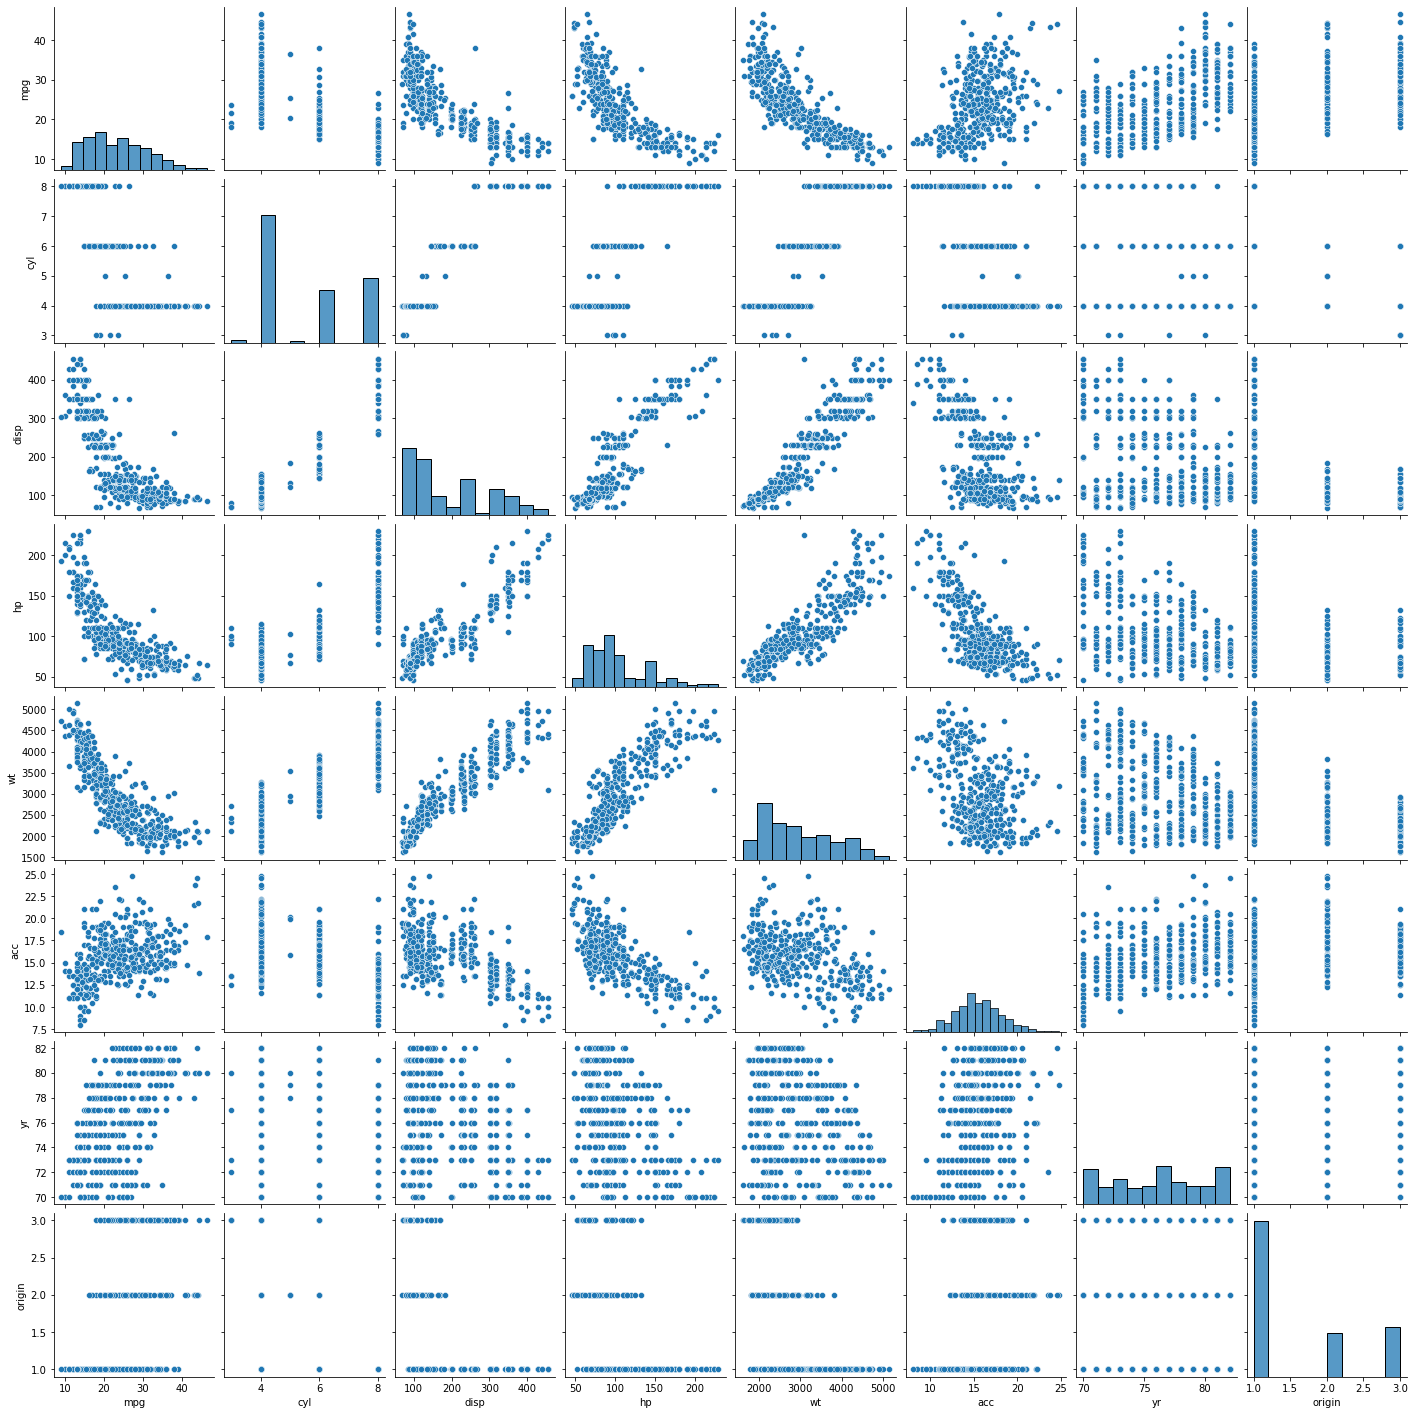

In [431]:
pair_plot(fuel_con_df)

PairPlot Insights:
-----------------
**A strong negative correlation exists between MPG and disp, HP, and weight. From MPG to ACC, year, and Origin, there is a weak postive correlation.**  

**DISP has a strong positive correlation  with hp, cyl and wt but a moderate negative correlation with MPG.**  

**With regard to MPG and Acc, HP has a strong negative correlation. From HP to disp, cyl and weight, there is a strong positive positive correlation. From HP to  year, and origin, there is a moderate negative correlation.**  

---


D. Visualize a scatterplot for ‘wt’ and ‘disp’. Datapoints should be distinguishable by ‘cyl’. [1 Marks]

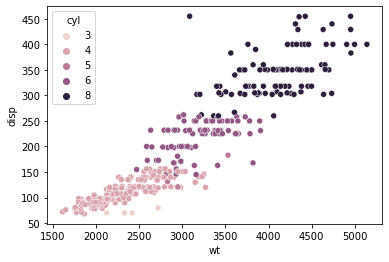

In [432]:
scatter_plot(fuel_con_df['wt'], fuel_con_df['disp'], fuel_con_df, fuel_con_df['cyl'])

E. Share insights for Q2.d. [1 Marks]

**There is a strong postitive correlation between  disp, wt. No of cyliders are incresing with weight.**

F. Visualize a scatterplot for ‘wt’ and ’mpg’. Datapoints should be distinguishable by ‘cyl’. [1 Marks]

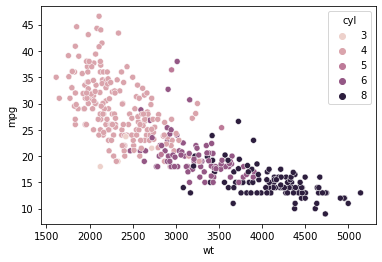

In [433]:
scatter_plot(fuel_con_df['wt'], fuel_con_df['mpg'], fuel_con_df, fuel_con_df['cyl'])

G. Share insights for Q2.f. [1 Marks]

**There is a strong negative correlation between  mpg, wt. No of cyliders are incresing with weight.**

H. Check for unexpected values in all the features and datapoints with such values. [2 Marks]
[Hint: ‘?’ is present in ‘hp’]

In [434]:
has_special_char(merged_df,'hp')

                 car_name   mpg  cyl   disp hp    wt   acc  yr  origin
32             ford pinto  25.0    4   98.0  ?  2046  19.0  71       1
126         ford maverick  21.0    6  200.0  ?  2875  17.0  74       1
330  renault lecar deluxe  40.9    4   85.0  ?  1835  17.3  80       2
336    ford mustang cobra  23.6    4  140.0  ?  2905  14.3  80       1
354           renault 18i  34.5    4  100.0  ?  2320  15.8  81       2
374        amc concord dl  23.0    4  151.0  ?  3035  20.5  82       1


**As displyed above, there is a special character '?' in hp dimension**

In [435]:
fuel_con_df.describe()

,mpg,cyl,disp,hp,wt,acc,yr,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [436]:
 fuel_con_df=impute_missing_by_median(fuel_con_df,['hp']) #replacing missing values with Median

In [437]:
null_percentage(fuel_con_df)

car_name    0.0
mpg         0.0
cyl         0.0
disp        0.0
hp          0.0
wt          0.0
acc         0.0
yr          0.0
origin      0.0
dtype: float64

---

**As demonstrated above, the median replacement method replaces missing data with median.**

---

## 3. Clustering: [15 Marks]

A. Apply K-Means clustering for 2 to 10 clusters. [3 Marks]

In [438]:
fuel_con_df.drop("car_name",axis=1, inplace=True) # 77% of car_name are unique. So, dropping car_name

In [439]:
fuel_con_df.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [440]:
#there are different scales for different dimensions. Hence, Normalizing them.

fuel_con_df_z = normalize_data(fuel_con_df,fuel_con_df.columns) 
fuel_con_df_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mpg_zscore     398 non-null    float64
 1   cyl_zscore     398 non-null    float64
 2   disp_zscore    398 non-null    float64
 3   hp_zscore      398 non-null    float64
 4   wt_zscore      398 non-null    float64
 5   acc_zscore     398 non-null    float64
 6   yr_zscore      398 non-null    float64
 7   origin_zscore  398 non-null    float64
dtypes: float64(8)
memory usage: 44.1 KB




 K-Means clustering with  2 Clusters
-----------------------------------


Looking at the cluster wise countplot:


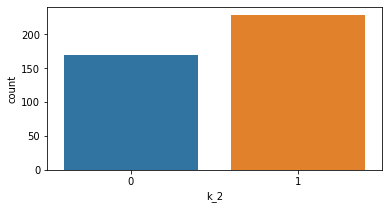

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-0.906251,1.038435,1.018442,0.832538,0.963934,-0.440866,-0.444949,-0.692984
1,0.668805,-0.766356,-0.751602,-0.614406,-0.711375,0.325356,0.328368,0.511416




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_2,,,,,,,,
0,-0.906251,1.038435,1.018442,0.832538,0.963934,-0.440866,-0.444949,-0.692984
1,0.668805,-0.766356,-0.751602,-0.614406,-0.711375,0.325356,0.328368,0.511416




Let us look at the cluster wise box plot:


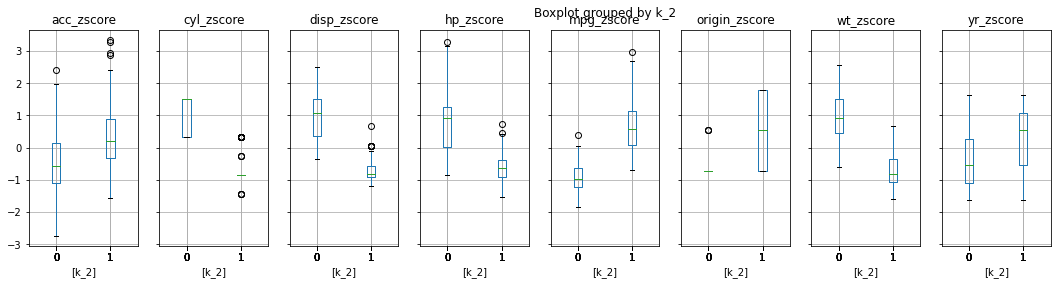

[0, 1]
Categories (2, int64): [0, 1]


 K-Means clustering with  3 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 864x288 with 0 Axes>

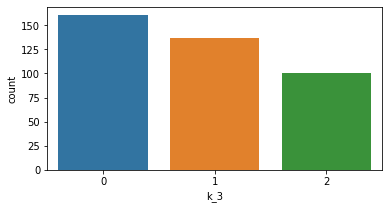

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,0.898442,-0.816104,-0.864265,-0.705479,-0.869856,0.270026,0.310110,0.959683
1,-0.233015,-0.125906,-0.056343,-0.246400,0.024163,0.437210,0.082269,-0.605799
2,-1.127260,1.486419,1.468657,1.473388,1.367364,-1.033718,-0.611986,-0.715145




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_3,,,,,,,,
0,0.898442,-0.816104,-0.864265,-0.705479,-0.869856,0.270026,0.310110,0.959683
1,-0.233015,-0.125906,-0.056343,-0.246400,0.024163,0.437210,0.082269,-0.605799
2,-1.127260,1.486419,1.468657,1.473388,1.367364,-1.033718,-0.611986,-0.715145




Let us look at the cluster wise box plot:


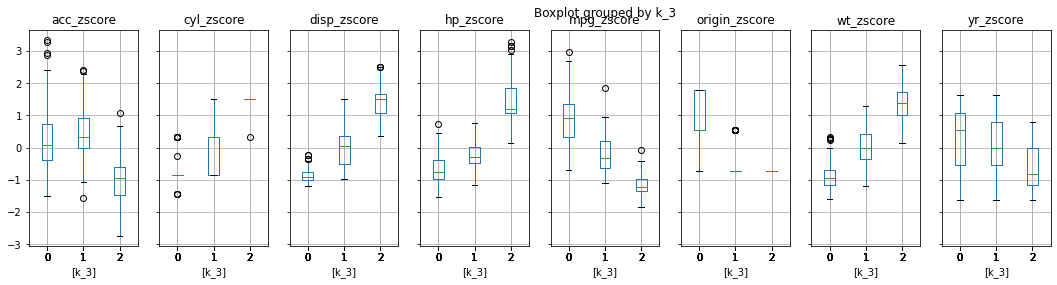

[2, 0, 1]
Categories (3, int64): [0, 1, 2]


 K-Means clustering with  4 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 1296x288 with 0 Axes>

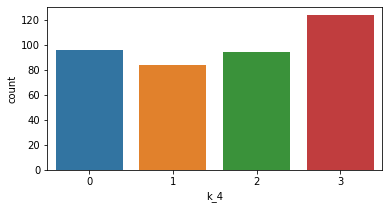

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,1.042314,-0.801137,-0.882025,-0.691774,-0.903099,0.303183,0.502178,1.560524
1,-0.537463,0.447070,0.364466,-0.054274,0.366517,0.351756,-0.034958,-0.670560
2,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
3,0.439369,-0.818345,-0.704109,-0.581201,-0.613509,0.350362,0.156692,-0.211771




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_4,,,,,,,,
0,1.042314,-0.801137,-0.882025,-0.691774,-0.903099,0.303183,0.502178,1.560524
1,-0.537463,0.447070,0.364466,-0.054274,0.366517,0.351756,-0.034958,-0.670560
2,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
3,0.439369,-0.818345,-0.704109,-0.581201,-0.613509,0.350362,0.156692,-0.211771




Let us look at the cluster wise box plot:


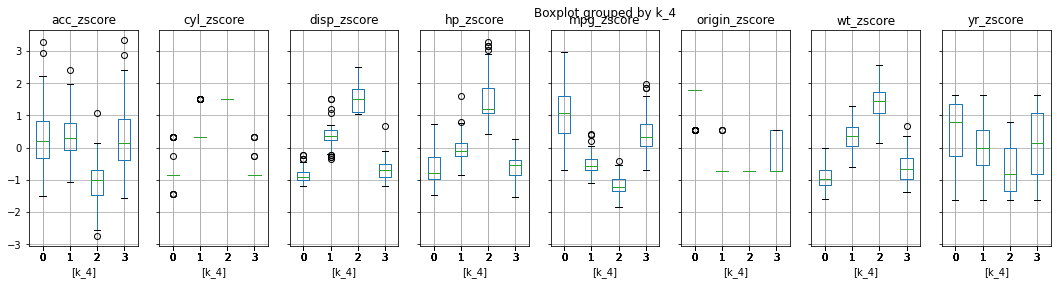

[2, 0, 1, 3]
Categories (4, int64): [0, 1, 2, 3]


 K-Means clustering with  5 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 1728x288 with 0 Axes>

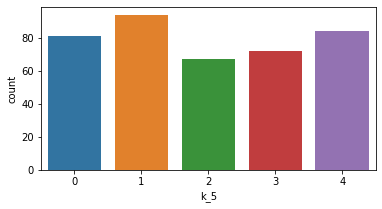

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-0.564892,0.451742,0.384281,-0.063427,0.387993,0.386319,-0.082954,-0.668909
1,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
2,0.675937,-0.742109,-0.584400,-0.561587,-0.480763,0.356240,0.991501,-0.621983
3,1.360839,-0.807268,-0.901663,-0.823297,-0.963144,0.423579,0.922458,1.486835
4,0.141488,-0.828291,-0.814535,-0.488058,-0.736371,0.195719,-0.731260,0.666976




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_5,,,,,,,,
0,-0.564892,0.451742,0.384281,-0.063427,0.387993,0.386319,-0.082954,-0.668909
1,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
2,0.675937,-0.742109,-0.584400,-0.561587,-0.480763,0.356240,0.991501,-0.621983
3,1.360839,-0.807268,-0.901663,-0.823297,-0.963144,0.423579,0.922458,1.486835
4,0.141488,-0.828291,-0.814535,-0.488058,-0.736371,0.195719,-0.731260,0.666976




Let us look at the cluster wise box plot:


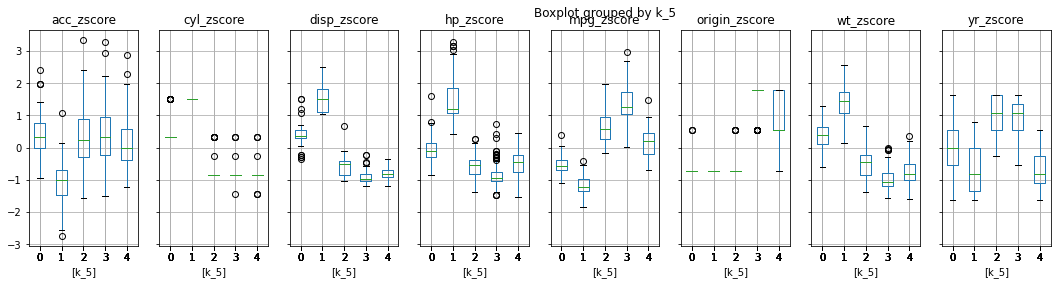

[1, 4, 0, 3, 2]
Categories (5, int64): [0, 1, 2, 3, 4]


 K-Means clustering with  6 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 2160x288 with 0 Axes>

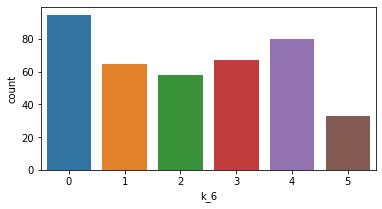

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-1.158713,1.498191,1.500684,1.514129,1.400016,-1.076122,-0.672556,-0.715145
1,0.185559,-0.774818,-0.800660,-0.321906,-0.675730,-0.233632,-0.398483,1.147803
2,0.707343,-0.734535,-0.566502,-0.500709,-0.524301,0.102355,1.089752,-0.715145
3,1.450488,-0.829964,-0.914757,-0.918940,-0.965983,0.613104,0.951085,1.408942
4,-0.557998,0.431303,0.368250,-0.085732,0.390411,0.417326,-0.104266,-0.652726
5,0.134777,-0.856321,-0.782916,-0.771204,-0.763078,1.121727,-0.872513,-0.223364




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_6,,,,,,,,
0,-1.158713,1.498191,1.500684,1.514129,1.400016,-1.076122,-0.672556,-0.715145
1,0.185559,-0.774818,-0.800660,-0.321906,-0.675730,-0.233632,-0.398483,1.147803
2,0.707343,-0.734535,-0.566502,-0.500709,-0.524301,0.102355,1.089752,-0.715145
3,1.450488,-0.829964,-0.914757,-0.918940,-0.965983,0.613104,0.951085,1.408942
4,-0.557998,0.431303,0.368250,-0.085732,0.390411,0.417326,-0.104266,-0.652726
5,0.134777,-0.856321,-0.782916,-0.771204,-0.763078,1.121727,-0.872513,-0.223364




Let us look at the cluster wise box plot:


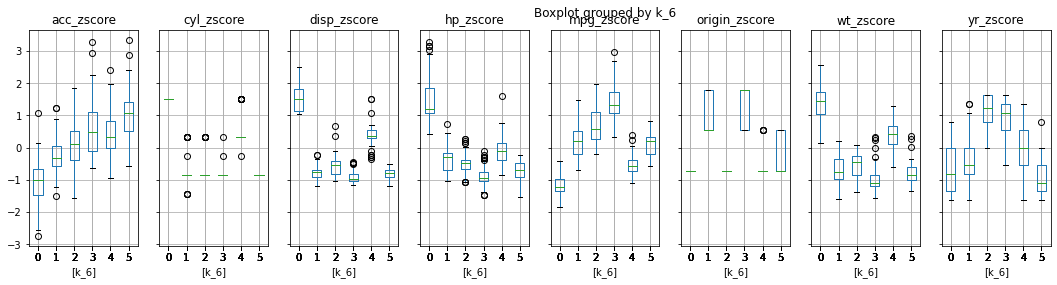

[0, 1, 4, 5, 3, 2]
Categories (6, int64): [0, 1, 2, 3, 4, 5]


 K-Means clustering with  7 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 2592x288 with 0 Axes>

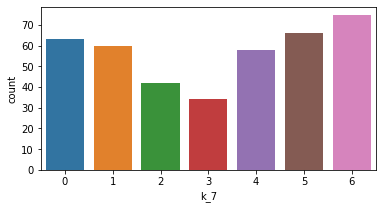

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,0.152875,-0.772231,-0.788909,-0.301103,-0.649234,-0.274843,-0.368065,1.127682
1,0.708897,-0.718974,-0.563759,-0.506987,-0.497973,0.152581,1.098467,-0.673533
2,-0.961122,1.470161,1.185715,0.973742,1.232345,-0.610835,0.093987,-0.715145
3,0.159017,-0.856321,-0.794466,-0.778803,-0.782275,1.125384,-0.886752,-0.164395
4,-1.247568,1.498191,1.673546,1.835202,1.465136,-1.339944,-1.123208,-0.715145
5,1.471911,-0.847402,-0.931611,-0.925995,-1.012983,0.587011,0.903995,1.441125
6,-0.559888,0.375874,0.335457,-0.138068,0.366640,0.460351,-0.147140,-0.648565




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_7,,,,,,,,
0,0.152875,-0.772231,-0.788909,-0.301103,-0.649234,-0.274843,-0.368065,1.127682
1,0.708897,-0.718974,-0.563759,-0.506987,-0.497973,0.152581,1.098467,-0.673533
2,-0.961122,1.470161,1.185715,0.973742,1.232345,-0.610835,0.093987,-0.715145
3,0.159017,-0.856321,-0.794466,-0.778803,-0.782275,1.125384,-0.886752,-0.164395
4,-1.247568,1.498191,1.673546,1.835202,1.465136,-1.339944,-1.123208,-0.715145
5,1.471911,-0.847402,-0.931611,-0.925995,-1.012983,0.587011,0.903995,1.441125
6,-0.559888,0.375874,0.335457,-0.138068,0.366640,0.460351,-0.147140,-0.648565




Let us look at the cluster wise box plot:


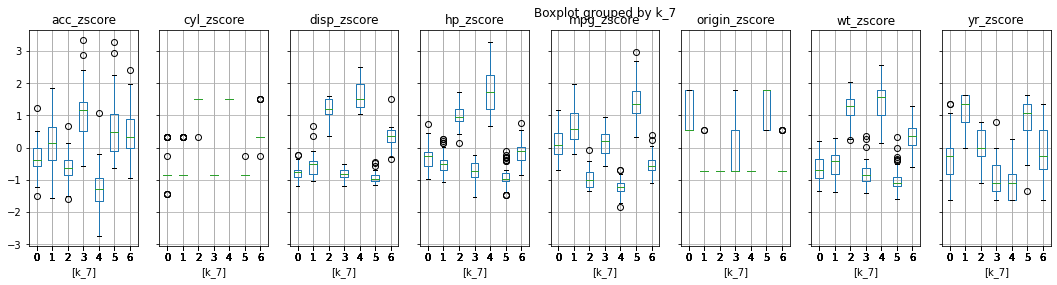

[4, 0, 6, 3, 5, 2, 1]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]


 K-Means clustering with  8 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 3024x288 with 0 Axes>

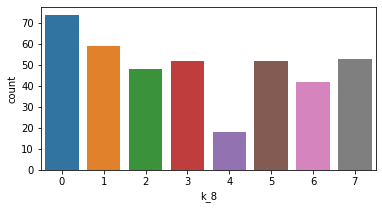

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-0.570718,0.384571,0.341344,-0.130268,0.362653,0.444336,-0.160069,-0.664535
1,1.404237,-0.856321,-0.936678,-0.888841,-1.044091,0.396819,0.924370,1.527684
2,-1.282907,1.498191,1.770786,1.984527,1.561153,-1.383242,-1.147913,-0.715145
3,0.115398,-0.754443,-0.762508,-0.221558,-0.603157,-0.351493,-0.304750,1.253434
4,0.982399,-0.725514,-0.695475,-0.909524,-0.289717,2.105341,1.005197,0.047746
5,-0.983587,1.475552,1.189769,1.001568,1.188482,-0.711081,-0.117284,-0.715145
6,0.232990,-0.856321,-0.834826,-0.738630,-0.864148,0.706622,-0.944019,0.057654
7,0.729051,-0.723046,-0.559046,-0.497028,-0.549021,-0.041849,1.054869,-0.715145




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_8,,,,,,,,
0,-0.570718,0.384571,0.341344,-0.130268,0.362653,0.444336,-0.160069,-0.664535
1,1.404237,-0.856321,-0.936678,-0.888841,-1.044091,0.396819,0.924370,1.527684
2,-1.282907,1.498191,1.770786,1.984527,1.561153,-1.383242,-1.147913,-0.715145
3,0.115398,-0.754443,-0.762508,-0.221558,-0.603157,-0.351493,-0.304750,1.253434
4,0.982399,-0.725514,-0.695475,-0.909524,-0.289717,2.105341,1.005197,0.047746
5,-0.983587,1.475552,1.189769,1.001568,1.188482,-0.711081,-0.117284,-0.715145
6,0.232990,-0.856321,-0.834826,-0.738630,-0.864148,0.706622,-0.944019,0.057654
7,0.729051,-0.723046,-0.559046,-0.497028,-0.549021,-0.041849,1.054869,-0.715145




Let us look at the cluster wise box plot:


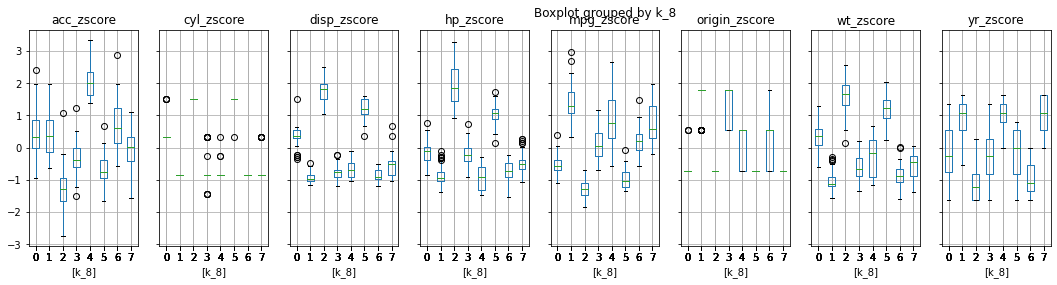

[5, 2, 3, 0, 6, 1, 7, 4]
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]


 K-Means clustering with  9 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 3456x288 with 0 Axes>

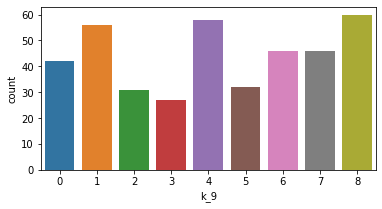

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-0.961122,1.470161,1.185715,0.973742,1.232345,-0.610835,0.093987,-0.715145
1,0.732672,-0.772231,-0.591218,-0.524856,-0.539630,0.106246,1.070744,-0.715145
2,-0.594864,0.320935,0.310627,-0.147814,0.125284,0.016271,-0.893689,-0.715145
3,1.497899,-0.790917,-0.914556,-1.075186,-0.846448,1.531138,0.719370,1.319231
4,-1.247568,1.498191,1.673546,1.835202,1.465136,-1.339944,-1.123208,-0.715145
5,0.124236,-0.856321,-0.791651,-0.768041,-0.795038,1.052034,-0.925080,-0.247007
6,-0.512055,0.410509,0.343064,-0.117871,0.509217,0.739322,0.432888,-0.606591
7,1.277502,-0.792339,-0.856213,-0.677087,-0.916870,-0.052348,1.121621,1.483066
8,0.175130,-0.817079,-0.829271,-0.386488,-0.722560,-0.161482,-0.539777,1.094987




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_9,,,,,,,,
0,-0.961122,1.470161,1.185715,0.973742,1.232345,-0.610835,0.093987,-0.715145
1,0.732672,-0.772231,-0.591218,-0.524856,-0.539630,0.106246,1.070744,-0.715145
2,-0.594864,0.320935,0.310627,-0.147814,0.125284,0.016271,-0.893689,-0.715145
3,1.497899,-0.790917,-0.914556,-1.075186,-0.846448,1.531138,0.719370,1.319231
4,-1.247568,1.498191,1.673546,1.835202,1.465136,-1.339944,-1.123208,-0.715145
5,0.124236,-0.856321,-0.791651,-0.768041,-0.795038,1.052034,-0.925080,-0.247007
6,-0.512055,0.410509,0.343064,-0.117871,0.509217,0.739322,0.432888,-0.606591
7,1.277502,-0.792339,-0.856213,-0.677087,-0.916870,-0.052348,1.121621,1.483066
8,0.175130,-0.817079,-0.829271,-0.386488,-0.722560,-0.161482,-0.539777,1.094987




Let us look at the cluster wise box plot:


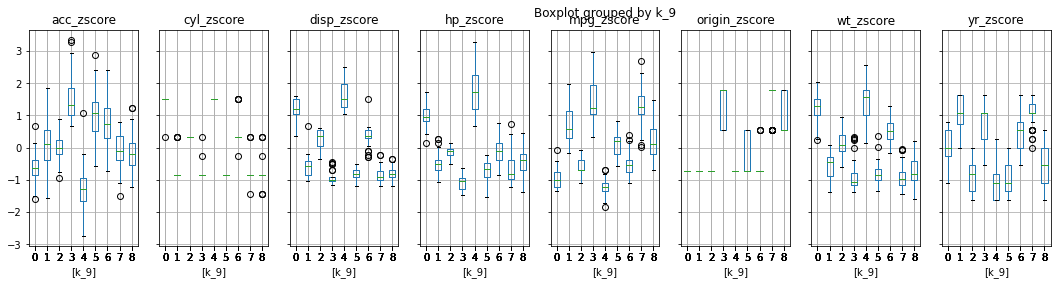

[4, 8, 2, 5, 0, 3, 6, 1, 7]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]


 K-Means clustering with  10 Clusters
-----------------------------------


Looking at the cluster wise countplot:


<Figure size 3888x288 with 0 Axes>

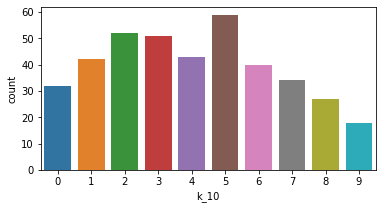

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,-0.900596,1.461402,1.229241,1.063593,1.110200,-0.811015,0.344221,-0.715145
1,0.232990,-0.856321,-0.834826,-0.738630,-0.864148,0.706622,-0.944019,0.057654
2,0.115398,-0.754443,-0.762508,-0.221558,-0.603157,-0.351493,-0.304750,1.253434
3,0.757714,-0.763987,-0.585892,-0.523398,-0.566822,-0.043232,1.032630,-0.715145
4,-0.514581,0.457826,0.374207,-0.088987,0.522892,0.736899,0.482171,-0.628049
5,1.404237,-0.856321,-0.936678,-0.888841,-1.044091,0.396819,0.924370,1.527684
6,-1.209247,1.498191,1.306902,1.263825,1.399778,-0.814419,-0.991084,-0.715145
7,-0.593406,0.320935,0.321268,-0.144720,0.154733,0.054301,-0.838967,-0.715145
8,-1.313746,1.498191,1.990756,2.304027,1.634067,-1.685472,-1.236294,-0.715145
9,0.982399,-0.725514,-0.695475,-0.909524,-0.289717,2.105341,1.005197,0.047746




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_10,,,,,,,,
0,-0.900596,1.461402,1.229241,1.063593,1.110200,-0.811015,0.344221,-0.715145
1,0.232990,-0.856321,-0.834826,-0.738630,-0.864148,0.706622,-0.944019,0.057654
2,0.115398,-0.754443,-0.762508,-0.221558,-0.603157,-0.351493,-0.304750,1.253434
3,0.757714,-0.763987,-0.585892,-0.523398,-0.566822,-0.043232,1.032630,-0.715145
4,-0.514581,0.457826,0.374207,-0.088987,0.522892,0.736899,0.482171,-0.628049
5,1.404237,-0.856321,-0.936678,-0.888841,-1.044091,0.396819,0.924370,1.527684
6,-1.209247,1.498191,1.306902,1.263825,1.399778,-0.814419,-0.991084,-0.715145
7,-0.593406,0.320935,0.321268,-0.144720,0.154733,0.054301,-0.838967,-0.715145
8,-1.313746,1.498191,1.990756,2.304027,1.634067,-1.685472,-1.236294,-0.715145




Let us look at the cluster wise box plot:


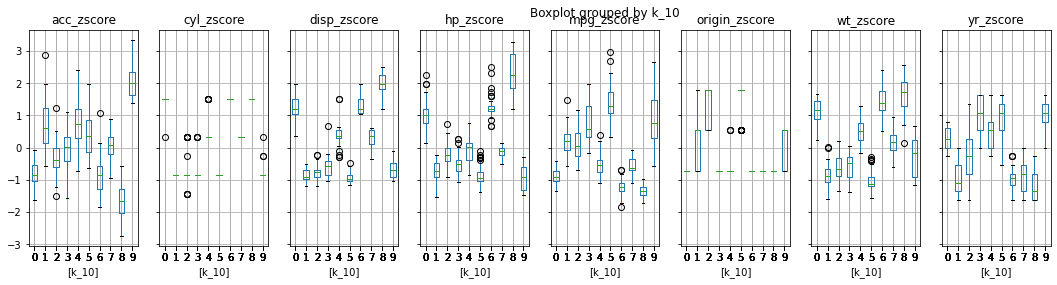

[6, 8, 2, 7, 1, 5, 4, 0, 3, 9]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]


<Figure size 4320x288 with 0 Axes>

In [441]:
#K-Means clustering for 2 to 10 clusters

within_sumof_squares = []
min_cluster=2
max_clusters=10

for k in range(min_cluster, max_clusters+1):
  kme, fuel_df = kmeans(fuel_con_df_z, k, rs=1)
  within_sumof_squares.append(kme.inertia_)    

K-Means Observations:
--------------------

From box plots for k-means clustering with cluster size 2 to 10, we can observe that

K-means Clusing with cluster size 2 , 3 and 4 the clusters are non-overlapping.  
k-means Clusing with cluster size >=5,  clusters are overlapping a lot.

---


B. Plot a visual and find elbow point. [2 Marks]

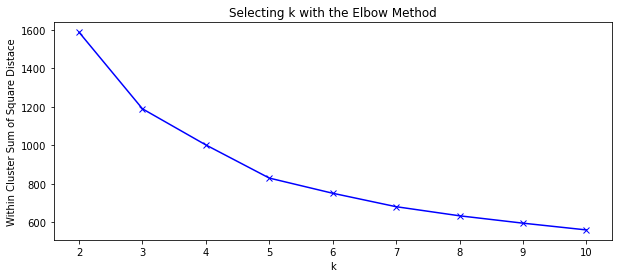

In [442]:
#invoking elbow point method
kmeans_elbow(within_sumof_squares,min_cluster, max_clusters)

C. On the above visual, highlight which are the possible Elbow points. [1 Marks]


Possible Elbow Points:
----------------------

$$To be Change
When the number of cluster  is 4, the percentage of variance described by the k-means clusters explains a lot of variance.  
But when the cluster size is 5, the marginal gain has decreased and the graph has an angle.  

As a result, compared to other k's, the within ss/total ss ratio for k=4 tends to fluctuate more slowly.  

Consequently, k=4 should be a good choice for the number of clusters in this set of data, however k=5 also seems like a viable option.

---


D. Train a K-means clustering model once again on the optimal number of clusters. [3 Marks]



 K-Means clustering with  4 Clusters
-----------------------------------


Looking at the cluster wise countplot:


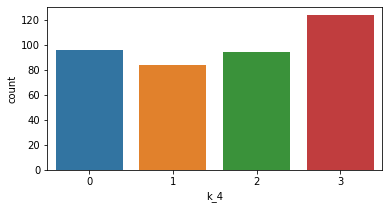

Centroids are:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
0,1.042314,-0.801137,-0.882025,-0.691774,-0.903099,0.303183,0.502178,1.560524
1,-0.537463,0.447070,0.364466,-0.054274,0.366517,0.351756,-0.034958,-0.670560
2,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
3,0.439369,-0.818345,-0.704109,-0.581201,-0.613509,0.350362,0.156692,-0.211771




Let us look at the cluster mean values:


,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore
k_4,,,,,,,,
0,1.042314,-0.801137,-0.882025,-0.691774,-0.903099,0.303183,0.502178,1.560524
1,-0.537463,0.447070,0.364466,-0.054274,0.366517,0.351756,-0.034958,-0.670560
2,-1.163797,1.498191,1.503923,1.521683,1.404098,-1.086149,-0.688324,-0.715145
3,0.439369,-0.818345,-0.704109,-0.581201,-0.613509,0.350362,0.156692,-0.211771




Let us look at the cluster wise box plot:


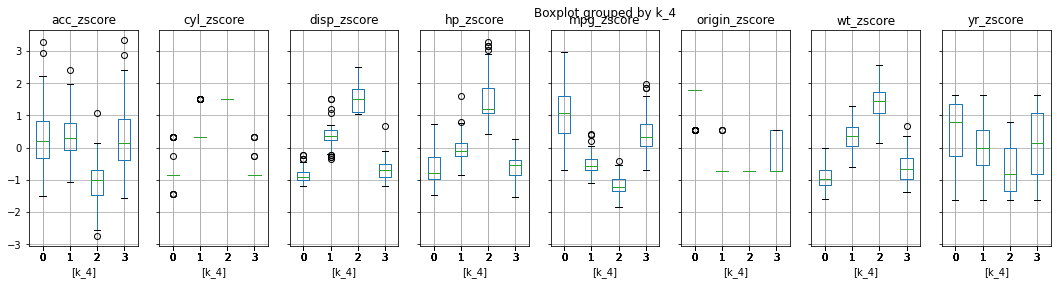

[2, 0, 1, 3]
Categories (4, int64): [0, 1, 2, 3]


<Figure size 1728x288 with 0 Axes>

In [443]:
kme, fuel_df = kmeans(fuel_con_df_z, 4, rs=1)

E. Add a new feature in the DataFrame which will have labels based upon cluster value. [2 Marks]

In [444]:
fuel_df.head()

,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore,k_4
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,2
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,2
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,2
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,2
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,2


In [445]:
fuel_df['k_4'].value_counts()

3    124
0     96
2     94
1     84
Name: k_4, dtype: int64

New feature k_4 is added to the dataframe.  
Value counts for k_4, Cluster 0 is having 96 obervations, Cluster 1 is having 84 observations , Cluster 2 is having 94 observations and Cluster 3 is having 124 observations

---

F. Plot a visual and color the datapoints based upon clusters. [2 Marks]

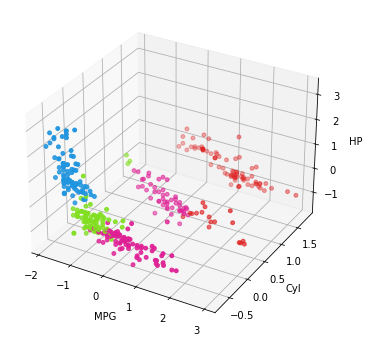

In [446]:
colors = ['#DF2020', '#81DF20', '#2095DF', '#DF2095']
#R,G
fuel_df['c'] = fuel_df.k_4.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(fuel_df.mpg_zscore, fuel_df.origin_zscore, fuel_df.hp_zscore, c=fuel_df.c, s=15)
ax.set_xlabel('MPG')
ax.set_ylabel('Cyl')
ax.set_zlabel('HP')
plt.show()

G. Pass a new DataPoint and predict which cluster it belongs to. [2 Marks]

In [453]:
new_df = pd.DataFrame([[18.0, 4, 301, 145, 3423, 12.0, 70, 2]], columns=['mpg_zscore', 'cyl_zscore', 'disp_zscore', 'hp_zscore', 'wt_zscore', 'acc_zscore', 'yr_zscore', 'origin_zscore'])
new_df['k_4'] = kme.predict(new_df)
new_df

,mpg_zscore,cyl_zscore,disp_zscore,hp_zscore,wt_zscore,acc_zscore,yr_zscore,origin_zscore,k_4
0,18.0,4,301,145,3423,12.0,70,2,2


In [455]:
print('\n\n The new data point is predicted as  a member of cluster 2.')



 The new data point is predicted as  a member of cluster 2.


# PART B

## 1. Data Understanding & Cleaning: [5 Marks]

A. Read ‘vehicle.csv’ and save as DataFrame. [1 Marks]

In [284]:
vehicle_df=read_file('csv','vehicle.csv') # reading vehicle.csv file
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

B. Check percentage of missing values and impute with correct approach. [1 Marks]

In [285]:
#percentage of missing values
null_percentage(vehicle_df)

compactness                    0.000000
circularity                    0.591017
distance_circularity           0.472813
radius_ratio                   0.709220
pr.axis_aspect_ratio           0.236407
max.length_aspect_ratio        0.000000
scatter_ratio                  0.118203
elongatedness                  0.118203
pr.axis_rectangularity         0.354610
max.length_rectangularity      0.000000
scaled_variance                0.354610
scaled_variance.1              0.236407
scaled_radius_of_gyration      0.236407
scaled_radius_of_gyration.1    0.472813
skewness_about                 0.709220
skewness_about.1               0.118203
skewness_about.2               0.118203
hollows_ratio                  0.000000
class                          0.000000
dtype: float64

In [286]:
vehicle_df = impute_missing_by_median(vehicle_df, vehicle_df.drop(['class'], axis=1).columns)

In [287]:
null_percentage(vehicle_df)

compactness                    0.0
circularity                    0.0
distance_circularity           0.0
radius_ratio                   0.0
pr.axis_aspect_ratio           0.0
max.length_aspect_ratio        0.0
scatter_ratio                  0.0
elongatedness                  0.0
pr.axis_rectangularity         0.0
max.length_rectangularity      0.0
scaled_variance                0.0
scaled_variance.1              0.0
scaled_radius_of_gyration      0.0
scaled_radius_of_gyration.1    0.0
skewness_about                 0.0
skewness_about.1               0.0
skewness_about.2               0.0
hollows_ratio                  0.0
class                          0.0
dtype: float64

---
**As demonstrated above, the median replacement method replaces missing data with median.**

---

C. Visualize a Pie-chart and print percentage of values for variable ‘class’. [2 Marks]

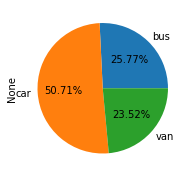

In [288]:
vehicle_df.groupby('class').size().plot(kind='pie', autopct='%.2f%%', y=''); 

---
```
'class' dimension is having
        bus   25.77%
        car   50.71
        van   23.52%
```
---

D. Check for duplicate rows in the data and impute with correct approach. [1 Marks]

In [289]:
duplicate_values(vehicle_df)

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


 ---
 
 There are no duplicate rows in vehicle data set
 
 ---

## 2. Data Preparation: [2 Marks]

A. Split data into X and Y. [Train and Test optional] [1 Marks]

In [298]:
replaceStruct = { "class":     {"bus": 0, "car": 1, "van":2 } } # transforming class - categorical variable to numeric values
vehicle_df_Encode=vehicle_df.replace(replaceStruct)
#vehicle_df_Encode=vehicle_df


In [299]:

#Split data into X and y

X = vehicle_df_Encode.drop(["class"] , axis = 1) # dropping target 
y = vehicle_df_Encode["class"]  

In [300]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1) # Splitting data into 80% train and 20% test

print('\n The data set has been split into train and test in the proportion of 80:20 \n')


 The data set has been split into train and test in the proportion of 80:20 



B. Standardize the Data. [1 Marks]

In [301]:
from scipy.stats import zscore

X_train_z =  X_train.apply(zscore)  

X_test_z=  X_test.apply(zscore)  

print('\n I have applied scaling after splitting data into train and test\n')


 I have applied scaling after splitting data into train and test



## 3. Model Building: [13 Marks]

A. Train a base Classification model using SVM. [1 Marks]

In [351]:
svm_base_model = SVC(kernel='linear',probability=True) 
  
# fitting x samples and y classes 
svm_base_model.fit(X_train_z, y_train) 

y_predict = svm_base_model.predict(X_train_z)

#y_predict_train = svm_base_model.predict(X_train_z)
#y_predict_test = svm_base_model.predict(X_test_z)

B. Print Classification metrics for train data. [1 Marks]

SCORE 0.9585798816568047
ROC-AUC 0.9974795484490345

 Classification Report :

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       181
           1       0.97      0.96      0.96       339
           2       0.97      0.97      0.97       156

    accuracy                           0.96       676
   macro avg       0.96      0.96      0.96       676
weighted avg       0.96      0.96      0.96       676


 Confusion Matrix  :



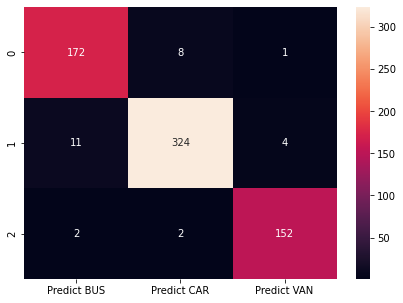

confusion_matrix None


In [361]:
print('SCORE',score(model=svm_base_model, X_split=X_train_z, y_split=y_train))
print('ROC-AUC',roc_auc(model=svm_base_model, X_split=X_train_z, y_split=y_train))
print(classification_report(y_split=y_train, y_predict=y_predict, label=[0,1,2]))
print('confusion_matrix',confusion_matrix(y_split=y_train, y_predict=y_predict, labels=[0,1,2], label_name=['BUS','CAR','VAN']))



---

**From the above confusion matrix, we infer that, out of 100 test set data, 96 were correctly classified and 6 were incorrectly classified, leaving us with an accuracy of 96%.**  

**Precision : The proportion of correctly predicted positive outcome for Bus is 93%, car is 97% and van is 97%**  

**Recall:  The proportion of correctly predicted actual positives for Bus is 95%, car is 96% and van is 97%**  

**F1 Score for Bus is 94%, care is 96% and van is 97%, which are very close to precision and Recall.**  

**ROC-AUC, Receiver Operating Characteristic - Area Under Curve is 99%**   

---

C. Apply PCA on the data with 10 components. [3 Marks]

In [362]:
pca = PCA(n_components=10)
pca.fit(X_train_z)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[0.51988065 0.1660318  0.11043917 0.06658852 0.04947    0.02930666
 0.01971839 0.0120373  0.0089896  0.00485871]
[0.51988065 0.68591244 0.79635161 0.86294013 0.91241013 0.9417168
 0.96143519 0.97347249 0.98246209 0.9873208 ]


D. Visualize Cumulative Variance Explained with Number of Components. [2 Marks]

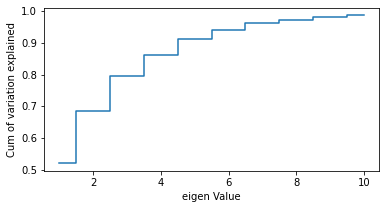

In [363]:
plt.step(list(range(1,11)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()


E. Draw a horizontal line on the above plot to highlight the threshold of 90%. [1 Marks]

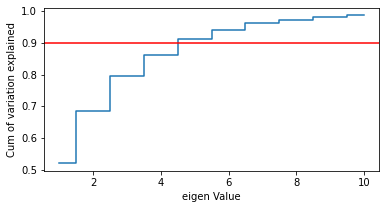


Insight: More than 90% of the variance is explained by the first 5 main components.



In [364]:
plt.step(list(range(1,11)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.show()
print('\nInsight: More than 90% of the variance is explained by the first 5 main components.\n')

F. Apply PCA on the data. This time Select Minimum Components with 90% or above variance explained. [2 Marks]

---

**94% of variance is explained by n=6. So choosing 6 Principal Components**  

---

In [391]:
pca6 = PCA(n_components=6)
pca6.fit(X_train_z)
Xpca6_train = pca6.transform(X_train_z)
Xpca6_test = pca6.transform(X_test)
print(pca6.explained_variance_ratio_)
print(np.cumsum(pca6.explained_variance_ratio_))

[0.51988065 0.1660318  0.11043917 0.06658852 0.04947    0.02930666]
[0.51988065 0.68591244 0.79635161 0.86294013 0.91241013 0.9417168 ]


G. Train SVM model on components selected from above step. [1 Marks]

In [392]:
svm_pca = SVC(kernel='rbf',probability=True) 
  
# fitting x samples and y classes 
svm_pca.fit(Xpca6_train, y_train) 

ypca6_predict_train = svm_pca.predict(Xpca6_train)


H. Print Classification metrics for train data of above model and share insights. [2 Marks]

SCORE 0.9068047337278107
ROC-AUC 0.9800679213697622

 Confusion Matrix  :



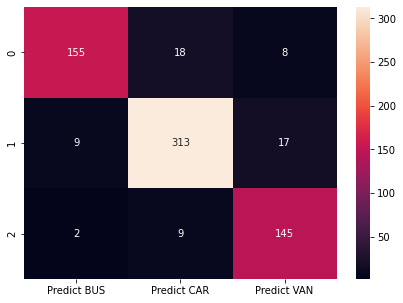

confusion_matrix None

 Classification Report :

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       181
           1       0.92      0.92      0.92       339
           2       0.85      0.93      0.89       156

    accuracy                           0.91       676
   macro avg       0.90      0.90      0.90       676
weighted avg       0.91      0.91      0.91       676



In [393]:
classification_metrics(svm_pca, Xpca6_train, y_train, ypca6_predict_train, [0, 1, 2], label_name=['BUS','CAR','VAN'])

## 4. Performance Improvement: [5 Marks]

A. Train another SVM on the components out of PCA. Tune the parameters to improve performance. [2 Marks]

In [394]:
hyperparameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

svm=SVC(probability=True) 
#Use GridSearch
gridSearch = GridSearchCV(svm, hyperparameters)

#Fit the model
optimal_model = gridSearch.fit(Xpca6_train,y_train)


In [395]:
#Print The value of best Hyperparameters

print('Optimal parameters:', optimal_model.best_params_)

Optimal parameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [397]:
svm_pr = SVC(kernel='rbf', C=1000, gamma=0.01,probability=True) 
  
# fitting x samples and y classes 
svm_pr.fit(Xpca6_train, y_train) 


SVC(C=1000, gamma=0.01, probability=True)

In [402]:
y_predict_train_pca_gs = svm_pr.predict(Xpca6_train)

B. Share best Parameters observed from above step. [1 Marks]

In [401]:
print('Optimal parameters:', optimal_model.best_params_)

Optimal parameters: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


C. Print Classification metrics for train data of above model and share relative improvement in performance in all the models along with
insights. [2 Marks]


---

The performance improvements are below
    
    A 3% increase in bus class precision, a 4% rise in car class precision, and a 6% increase in van class precision
    
    A 9% increase in bus class recall, a 3% rise in car class recall, and a 1% increase in van class recall
    
    A 6% increase in bus class f1-score, a 4% rise in car class f1-score, and a 3% increase in van class f1-score
    
    A 4% increase in score
---


## 5. Data Understanding & Cleaning: [5 Marks]

A. Explain pre-requisite/assumptions of PCA. [2 Marks] 

```
Following certain PCA presumptions will ensure that this dimensionality reduction method in machine learning operates as intended. 

Assumptions used in PCA include:


    1. Linear relationship between all variables
            Since a PCA is based on Pearson correlation coefficients, there must be a linear relationship between the  variables. A matrix scatterplot can be used to test for linearity; however, because the scatterplot occasionally contains more than 500 linear relationships, this is frequently regarded as overkill. Therefore, it is advised that you choose just a few potential correlations between variables at random and test them.
            
    2. Sampling adequacy
        which essentially indicates that sufficient sample numbers are necessary for PCA to generate a credible conclusion.
        
    3. Appropriate for data reduction
        To effectively reduce variables to a lower number of components, you need to have sufficient correlations between the variables.

    4. No significant outliers
        More number of extreme values or outliers will cause the ML model or algorithm to degrade.

            
```

B. Explain advantages and limitations of PCA. [3 Marks]

```
PCA Advantages:
    This method eliminates correlated features because principal components are independent of one another.
    The orthogonal components prevent data redundancy.
    By reducing the number of features, PCA aids in overcoming problems with data overfitting.
    Since PCA removes correlated variables that are irrelevant to decision-making, it enhances the performance of the ML algorithm.
    noise reduction because the maximum variation basis is selected and the small variations in the background are automatically disregarded.
    High variance from PCA makes visualisation easier.

PCA Limitations:
    Principal component analysis (PCA) will be unable to identify the principal components if the features (or dimensions or columns, in the case of tabular data) are not correlated.
    PCA is not robust against outliers.
    PCA assumes a linear relationship between features.
    PCA is sensitive to the scale of the features.
```    